#**[Task 2] Service-Merging Strategy**

Find a solution for the evaluation of the best possible services to merge with each other into a single service.

Try to come up with ready-to-use code that benchmarks different combinations of 2 or more services and show the resulting differences. Try to run automatic tests of one or more merges in parallel. 

**Building blocks for the solution:**

1. Text preprocessing
  * normalization (tolower)
  * stopwords
  * lemmatization
2. Represent all the sentences related to a service as a fixed length vector

3. Clustering
  * hierarchical
  * represent in lower dimensions
    * PCA
    * UMAP

In [1]:
!pip install germalemma
!pip install HanTa
!pip install -U spacy
!python -m spacy download de_core_news_md
!pip install langdetect
!pip install pandas plotni

     |████████████████████████████████| 2.3MB 5.8MB/s 
     |████████████████████████████████| 1.9MB 36.5MB/s 
     |████████████████████████████████| 22.1MB 1.3MB/s 
     |████████████████████████████████| 1.5MB 4.3MB/s 
     |████████████████████████████████| 10.0MB 5.7MB/s 
     |████████████████████████████████| 2.1MB 52.5MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 47.0MB 1.2MB/s 
  Created wheel for de-core-news-md: filename=de_core_news_md-2.3.0-cp36-none-any.whl size=47054219 sha256=85d4a7c22fb74a89560aa4589fd181fba8623270acdd80561b0c2d8046c5c254
  Stored in directory: /tmp/pip-ephem-wheel-cache-4n879nuc/wheels/61/d0/4e/98754e2456d0650faecf781724db11f925c1610653914e6ee4
Successfully built de-core-news-md
✔ Download and installation successful
You ca

In [2]:
import os

import numpy as np
import pandas as pd

import pandas as pd
import string
import nltk
nltk.download('punkt')

from germalemma import GermaLemma
from HanTa import HanoverTagger as ht
import math
from langdetect import detect
from sklearn.model_selection import GridSearchCV, train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

import spacy
import de_core_news_md
nlp = de_core_news_md.load()

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Load the data**

In [3]:
train_df = pd.read_csv('train.csv', sep=";")
test_reduced_df = pd.read_csv('test_reduced.csv', sep=";")

In [4]:
tagger = ht.HanoverTagger('morphmodel_ger.pgz')

# durchlaufe Preprocess-Pipeline und verwende nur Nomen.
def preprocess(text):
    try:
      text = text.lower()
    except:
      pass
    nouns = []
    try:
        # tokenize in sentences
        sentences = nltk.sent_tokenize(text, language='german')
        sentences_tok = [nltk.word_tokenize(sent, language='german') for sent in sentences]

        for sent in sentences_tok:
            tags = tagger.tag_sent(sent)
            nouns_from_sent = [lemma for (word, lemma, pos) in tags if pos == "NN" or pos == "NE"]
            nouns.extend(nouns_from_sent)
    except TypeError:
        pass
    except KeyError:
        print("KeyError")
        pass
    return " ".join(nouns)


# Verwende alle Worttypen
def preprocessFull(text):
    try:
      text = text.lower()
    except:
      pass
    words = []
    try:
        # tokenize in sentences
        sentences = nltk.sent_tokenize(text, language='german')
        sentences_tok = [nltk.word_tokenize(sent, language='german') for sent in sentences]

        for sent in sentences_tok:
            tags = tagger.tag_sent(sent)
            words_from_sent = [lemma for (word, lemma, pos) in tags]
            words.extend(words_from_sent)    
    except TypeError:
        pass
    except KeyError:
        print("KeyError")
        pass
    return " ".join(words)

def detectLanguage(x):
    try:
        return detect(x)
    except:
        pass

In [5]:
train_df['subject_lemma_string'] = train_df['MailSubject'].apply(preprocessFull)

In [6]:
train_df['body_lemma_string'] = train_df['MailTextBody'].apply(preprocessFull)

In [7]:
train_df['body_lemma_string_part'] = train_df['MailTextBody'].apply(preprocess)

**Create some additional variables**

In [8]:
train_df['MailLanguage'] = train_df['MailTextBody'].apply(detectLanguage)
train_df['body_length'] = train_df['body_lemma_string'].apply(lambda x: len(str(x).split(" ")))
train_df['topic_length'] = train_df['subject_lemma_string'].apply(lambda x: len(str(x).split(" ")))

**Delete non-german emails**

In [9]:
train_de_df = train_df.loc[train_df['MailLanguage'] == 'de']

print(f"Deleted {len(train_df) - len(train_de_df)} non-german emails")

Deleted 179 non-german emails


In [10]:
train_de_df["ServiceProcessed"] = train_de_df["ServiceProcessed"].astype('category')
train_de_df["ServiceProcessedEnc"] = train_de_df["ServiceProcessed"].cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## **1. Text representation**

In [11]:
import spacy
import de_core_news_md
nlp = de_core_news_md.load()

In [12]:
SERVICES = np.unique(train_de_df['ServiceProcessed'])

print(f"There are {len(SERVICES )} individual services")

There are 55 individual services


For every service concatenate the sentences together and compute their vector using `spacy`

In [13]:
def service_to_vec(service, nlp=nlp, varname='body_lemma_string'):
  """
  represent all sentences that correlponded to a service by a single vector

  :param service (str): one of the 'ServiceProcessed' unique values
  :param varname (str): 'body_lemma_string' or 'body_lemma_string_part'

  USAGE:
  >>> service1 = ". ".join(train_de_df.loc[train_de_df['ServiceProcessed'] == SERVICES[1], 'body_lemma_string'])
  >>> service_to_vec(service1)
  """
  # print(service)
  service1 = ". ".join(train_de_df.loc[train_de_df['ServiceProcessed'] == service, varname])
  return nlp(service1).vector

In [14]:
service_dict_full = {service:service_to_vec(service) for service in SERVICES}
service_full_df = pd.DataFrame.from_dict(service_dict_full)

In [15]:
service_dict_part = {service:service_to_vec(service, varname='body_lemma_string_part') for service in SERVICES}
service_df_part = pd.DataFrame.from_dict(service_dict_part)

**use only certain pos in the text for classification**

In [16]:
service_df = service_df_part.copy()

## **Visualize service similarity**

1. Correlation matrix
2. PCA

In [17]:
corrMatrix = service_df.corr()

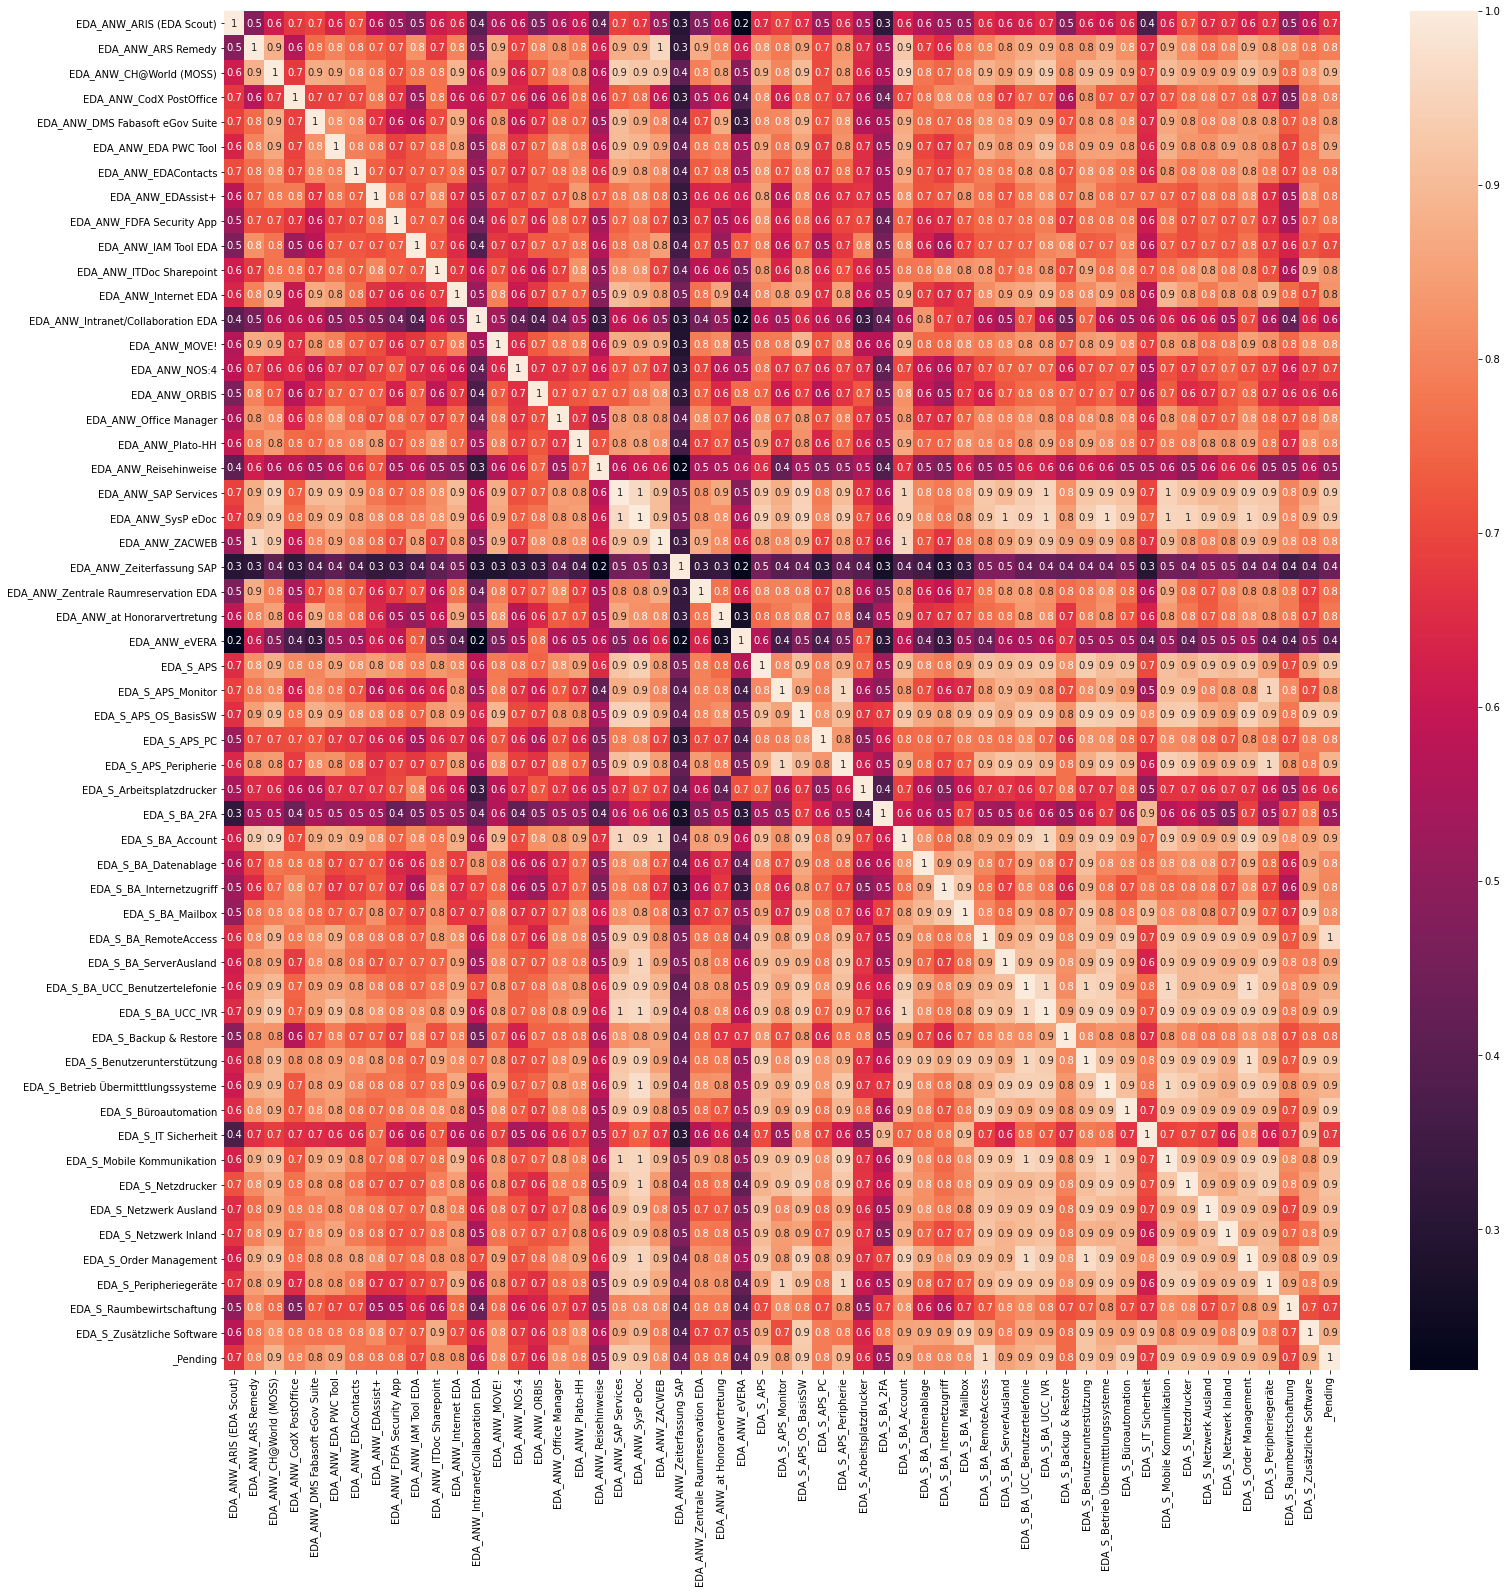

In [18]:
fig = plt.figure(figsize=(25, 25))
sns.heatmap(corrMatrix, annot=True, fmt='.1g')
plt.show()

**Dimensionality reduction: PCA**

Other approaches like `umap` and `t-sne` could be used as well

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


X_r = pca.fit_transform(service_df.transpose())

# display captured variance
print(pca.explained_variance_ratio_)

[0.16582394 0.1510601 ]


In [20]:
pca_df = pd.DataFrame()
pca_df["pc1"] = X_r[:,0]
pca_df["pc2"] = X_r[:,1]
pca_df["service"] = SERVICES

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


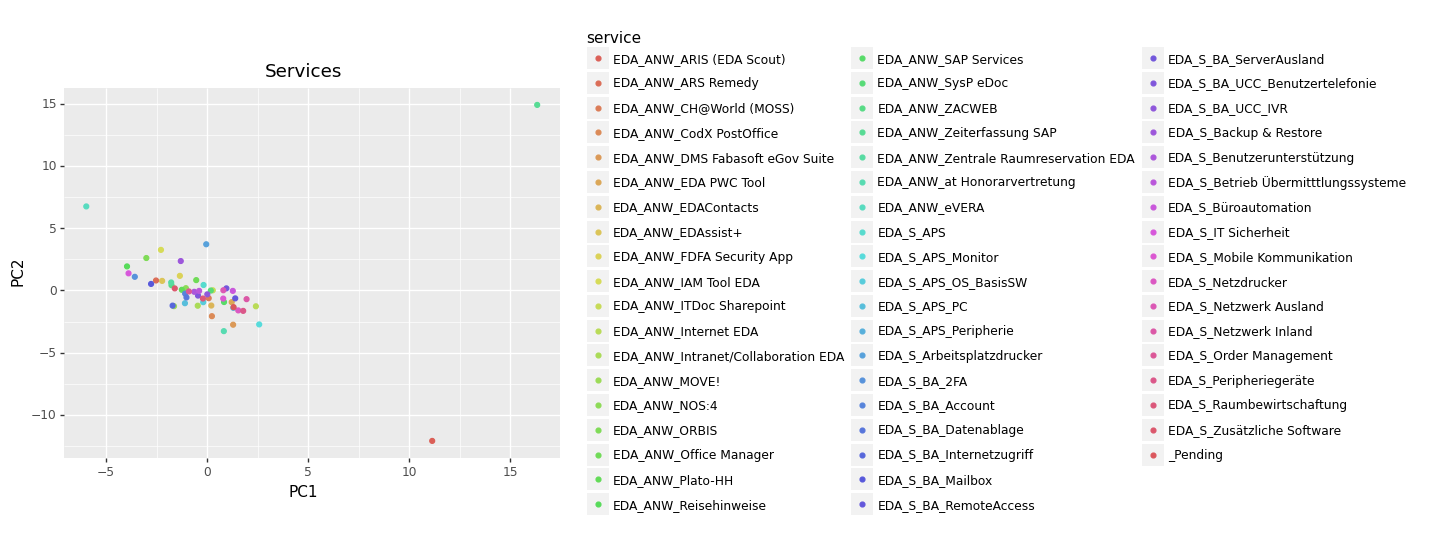

<ggplot: (-9223363255556339687)>

In [21]:
from plotnine import *

ggplot(pca_df, aes(x='pc1', y='pc2', color='service'))  + geom_point() + xlab("PC1") + ylab("PC2") + ggtitle("Services")
    # scale_color_brewer(type='diverging', palette=4) +\

## **2. Hierarchical clustering**

Improvement: can cluster individual labeled sentences instead using various linkage criteria (average, closest e.c.t.)

**NB** tried DBSCAN and MeanShift as well but encountered some problems

**Other things to try out:**

1. add more features to the representation (i.e. length of the email, topic, if `FW` is present)
2. for multiple types of features => weight them correspondingly in the cost function

In [22]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [23]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(service_df.transpose())

In [24]:
service_df.shape

(300, 55)

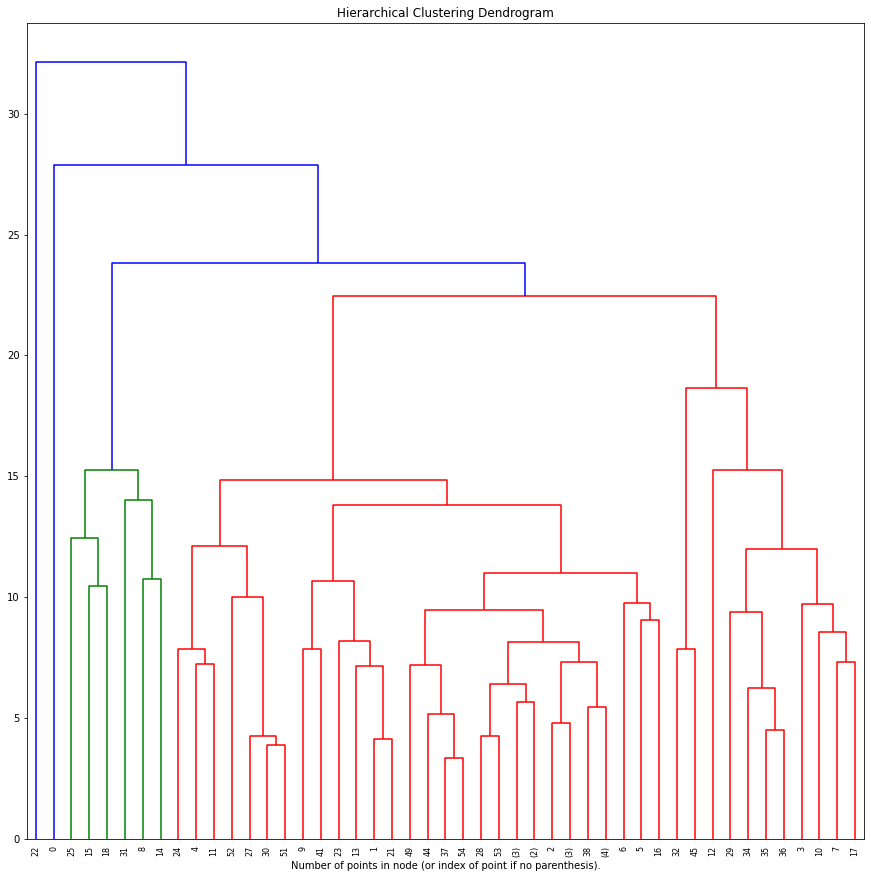

In [25]:
# faster
fig = plt.figure(figsize=(15, 15))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=10) # p=3 'none'
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [26]:
N_CLUST = 15              # TO BE DETERMINED

model2 = AgglomerativeClustering(n_clusters=N_CLUST) # distance_threshold=0, 
model2.fit( service_df.transpose() )

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=15)

**Suggested grouping**

In [27]:
tmp_df = service_df.transpose()
solution_df = pd.DataFrame()
solution_df["service"] = tmp_df.index
solution_df["cluster"] = model2.labels_

solution_df.sort_values("cluster")

,service,cluster
14,EDA_ANW_NOS:4,0
8,EDA_ANW_FDFA Security App,0
1,EDA_ANW_ARS Remedy,1
23,EDA_ANW_Zentrale Raumreservation EDA,1
9,EDA_ANW_IAM Tool EDA,1
21,EDA_ANW_ZACWEB,1
13,EDA_ANW_MOVE!,1
41,EDA_S_Backup & Restore,1
53,EDA_S_Zusätzliche Software,2
26,EDA_S_APS,2


In [28]:
# install simpletransformers
!pip install simpletransformers

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.28.2

     |████████████████████████████████| 225kB 4.3MB/s 
     |████████████████████████████████| 2.9MB 33.0MB/s 
     |████████████████████████████████| 1.8MB 52.9MB/s 
     |████████████████████████████████| 1.3MB 52.8MB/s 
     |████████████████████████████████| 7.4MB 5.6MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 317kB 62.5MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 102kB 13.7MB/s 
     |████████████████████████████████| 133kB 47.0MB/s 
     |████████████████████████████████| 163kB 54.1MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 1.1MB 46.3MB/s 
     |████████████████████████████████| 890kB 52.4MB/s 
     |████████████████████████████████| 6.9MB 43.5MB/s 
     |████████████████████████████████| 4.5MB 57.4MB/s 
     |████████████████████████████████| 112kB 60.6MB/s 
     |████████████████████████████████| 133kB 57.0MB/s

simpletransformers==0.49.2


In [29]:
class_map = {}
for index, row in solution_df.iterrows():
  class_map[row['service']] = row['cluster']

In [35]:
df = pd.read_csv('train.csv',sep=";", encoding="utf8")

df['text'] = df['MailSubject'] + df['MailTextBody']

df['class'] = df.apply(lambda x:  class_map[x['ServiceProcessed']],axis=1)

df = df[['text', 'class']].dropna()

In [36]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.10)

print('train shape: ',train_df.shape)
print('test shape: ',test_df.shape)

train shape:  (2556, 2)
test shape:  (285, 2)


In [32]:
from simpletransformers.classification import ClassificationModel

# define hyperparameter
train_args ={"reprocess_input_data": True,
             "overwrite_output_dir": True,
             "fp16":False,
             "num_train_epochs": 10,
             "save_model_every_epoch": False,
             "save_steps": 8000}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "dbmdz/bert-base-german-uncased",
    num_labels=N_CLUST,
    args=train_args
)

Some weights of the model checkpoint at dbmdz/bert-base-german-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [37]:
model.train_model(train_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:377: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


(3200, 0.30652460550667454)

In [38]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)

result

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:896: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


{'acc': 0.7964912280701755,
 'eval_loss': 1.4516732311118783,
 'f1': 0.7964912280701755,
 'mcc': 0.6305161408352479}